In [1]:
import pickle
from tqdm import tqdm
from puf import single_bit_flip_test
import numpy as np
import matplotlib.pyplot as plt


In [10]:
N_CHL_BITS = 10
CENTER_CHLS = [i for i in range(2**N_CHL_BITS)]

def crp_to_dist_to_half(crpss):
    flipped_prob = np.array([
        single_bit_flip_test(
            n_chl_bit=N_CHL_BITS,
            crps=crps,
            center_chls=CENTER_CHLS,
        )
        for crps in tqdm(crpss)
    ])

    dist_to_half = np.abs(flipped_prob - 0.5)
    return dist_to_half


def plot_convergence(ax: plt.Axes, data, title):
    cum_sum = np.cumsum(data)
    cum_mean = cum_sum / np.arange(1, len(data) + 1)
    ax.plot(cum_mean, label='Cumulative mean')
    ax.axhline(np.mean(data), color='red', linestyle='--', label='Mean')
    ax.set_xlabel('Sample id')
    ax.set_ylabel('Avg. dist to 0.5')
    ax.set_title(title)
    ax.legend()

def plot_distribution(ax: plt.Axes, data, title):
    ax.hist(data, bins=100, density=True, label='PMF')
    ax.axvline(np.mean(data), color='red', linestyle='--', label='Mean')
    ax.axvline(np.median(data), color='orange', linestyle='--', label='Median')
    ax.set_xlabel('Value')
    ax.set_ylabel('Percetange(%)')
    ax.set_title(title + f": Mean={np.mean(data):.3f}, Median={np.median(data):.3f}, Std={np.std(data):.3f}")
    ax.legend()

TIME_PONTS = np.linspace(*[0, 2.5e-8], 1001, endpoint=True)
def time_to_index(t):
    return int(t / TIME_PONTS[1])

def plot_time_series_list(ax: plt.Axes, data, title):
    for d in data:
        ax.plot(TIME_PONTS, d)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Distance to 0.5')
    ax.set_title(title)

def plot_time_series_with_std(ax: plt.Axes, data, title):
    mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    min_traj, max_traj = np.min(data, axis=0), np.max(data, axis=0)
    ax.plot(TIME_PONTS, mean, label='Mean')
    ax.plot(TIME_PONTS, min_traj, label='Min')
    ax.plot(TIME_PONTS, max_traj, label='Max')
    ax.fill_between(TIME_PONTS, mean - std, mean + std, alpha=0.5, label='Std')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Distance to 0.5')
    ax.legend(loc='upper right')
    ax.set_title(title)


In [11]:

def plot_ss_puf_rsp(dist_to_half):

    # Define the cost as the average bf distance to 0.5 over all the bits and timepoints
    fig, axes = plt.subplots(2, 1)
    mean_dist_to_half = np.mean(np.mean(dist_to_half, axis=1), axis=1)
    plot_convergence(axes[0], mean_dist_to_half, 'Avg cost v.s. # of samples')
    plot_distribution(axes[1], mean_dist_to_half, 'Cost Distribution')
    plt.suptitle('Cost: Avg. distance to 0.5 over 0~25ns and all challenge bit positions')
    plt.tight_layout()
    plt.show()

    mean_dist_to_half_over_chls = np.mean(dist_to_half, axis=1)
    fig, axes = plt.subplots(1, 1)
    plot_time_series_with_std(axes, mean_dist_to_half_over_chls, 'Avg. cost (over all bit positions) vs. Time')
    plt.show()
    
    idx_10ns, idx_15ns = time_to_index(10e-9), time_to_index(15e-9)
    mean_cost_between_10_15ns = np.mean(mean_dist_to_half_over_chls[:, idx_10ns:idx_15ns], axis=1)
    fig, axes = plt.subplots(2, 1)
    plot_convergence(axes[0], mean_cost_between_10_15ns, 'Avg cost v.s. # of samples')
    plot_distribution(axes[1], mean_cost_between_10_15ns, 'Cost Distribution')
    plt.suptitle('Cost: Avg. distance to 0.5 over 10-15ns and all challenge bit positions')
    plt.tight_layout()
    plt.show()

def plot_arbiter_puf_rsp(dist_to_half):

    mean_dist_to_half = np.mean(np.mean(dist_to_half, axis=1), axis=1)
    fig, axes = plt.subplots(2, 1)
    plot_convergence(axes[0], mean_dist_to_half, 'Avg cost v.s. # of samples')
    plot_distribution(axes[1], mean_dist_to_half, 'Cost Distribution')
    plt.suptitle('Arbiter PUF, Cost: Avg. distance to 0.5 over all challenge bit positions')
    plt.tight_layout()
    plt.show()



100%|██████████| 4096/4096 [03:41<00:00, 18.48it/s]


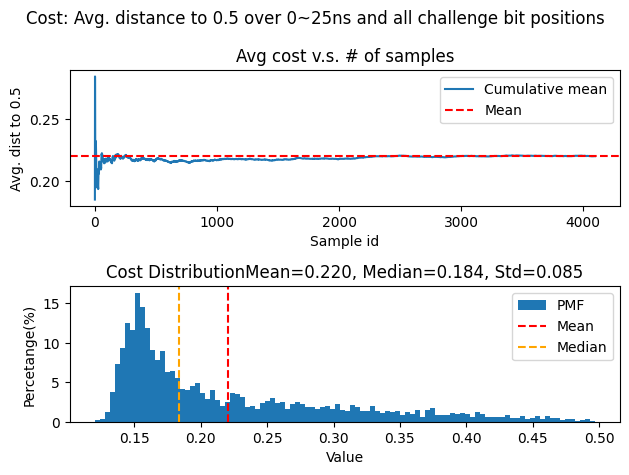

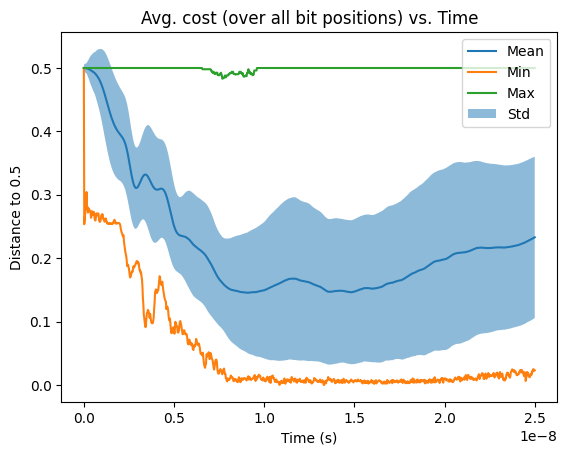

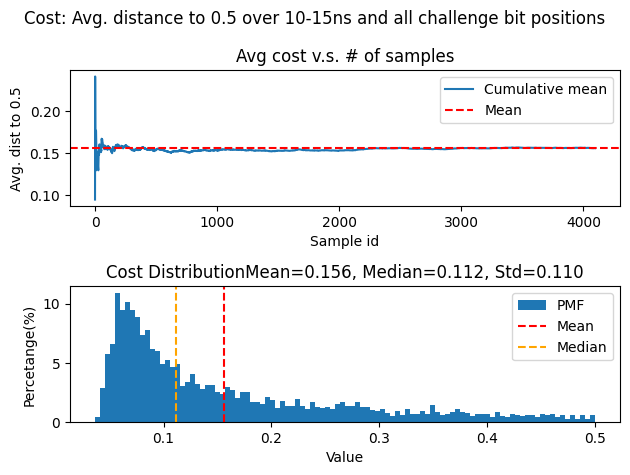

In [12]:
crpss = pickle.load(open("crpss.pkl", 'rb'))
dist_to_half_ss_orig = crp_to_dist_to_half(crpss)
plot_ss_puf_rsp(dist_to_half_ss_orig)

100%|██████████| 4096/4096 [03:42<00:00, 18.38it/s]


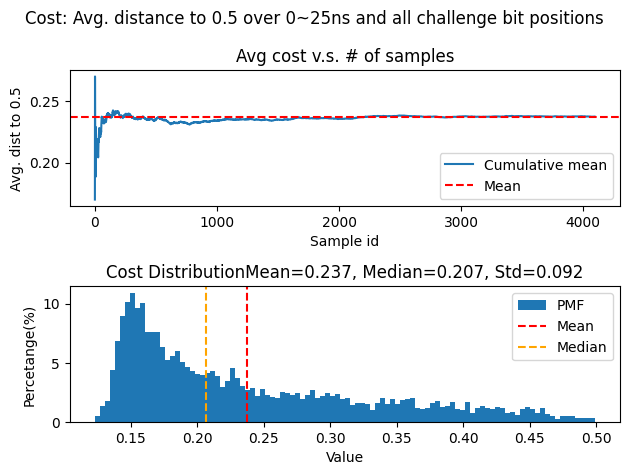

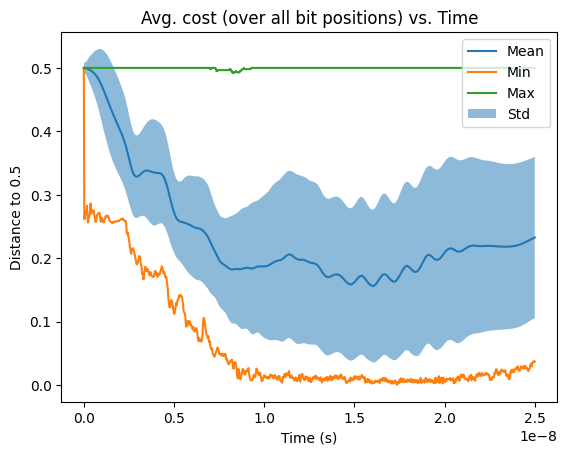

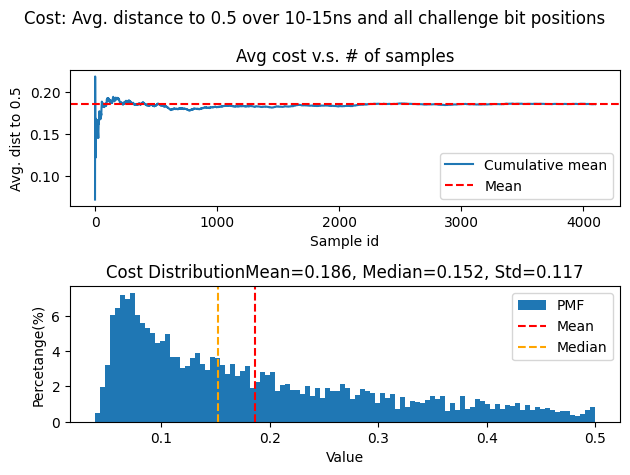

In [13]:
# Variant: middle capacitors are always kept identical to 1nF
# Surprisingly the cost is higher, why?
crpss = pickle.load(open("crpss_mid_cap_nominal.pkl", 'rb'))
dist_to_half_ss_mid_cap_nominal = crp_to_dist_to_half(crpss)
plot_ss_puf_rsp(dist_to_half_ss_mid_cap_nominal)

100%|██████████| 4096/4096 [03:35<00:00, 19.00it/s]


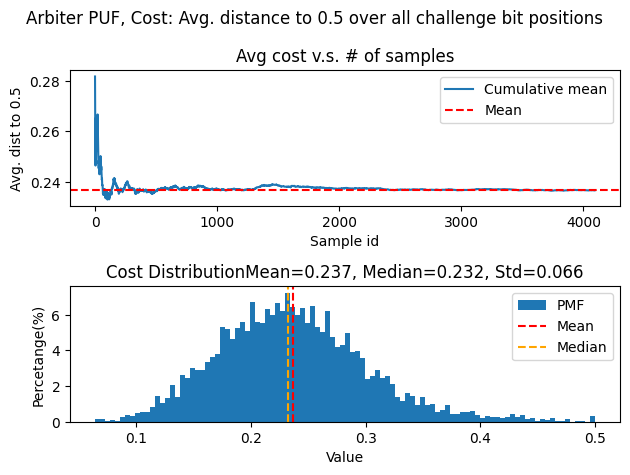

In [15]:
crpss = pickle.load(open("arbiter_crpss.pkl", 'rb'))
dist_to_half_arbiter = crp_to_dist_to_half(crpss)
plot_arbiter_puf_rsp(dist_to_half_arbiter)

In [ ]:
max_cost_id = np.argmax(mean_dist_to_half)
fig, axes = plt.subplots(1, 1)
print(max_cost_id)
plot_time_series_list(axes, dit_to_half[max_cost_id], 'Cost v.s. Time')

"""
max_cost_id = 838
I checked the transient response of instance 838 and it did shows that PUF 0 has a larger response than PUF 1 almost all the time
Didn't find any obvious odd parameter in them two.
"""

param_838 = {
    "InpI_0": {
        "fn": "functools.partial(<function pulse at 0x115d78cc0>, rise_time=5e-10, fall_time=5e-10, pulse_width=1e-09)",
        "g": 0.0,
    },
    "InpI_1": {
        "fn": "functools.partial(<function pulse at 0x115d78cc0>, rise_time=5e-10, fall_time=5e-10, pulse_width=1e-09)",
        "g": 0.0,
    },
    "MmI_0": {"l": 8.467457278414937e-10, "r": 0.0},
    "MmI_1": {"l": 9.857403781567268e-10, "r": 0.0},
    "MmI_10": {"l": 1.2387811370566265e-09, "r": 0.0},
    "MmI_11": {"l": 1.0485093372949952e-09, "r": 0.0},
    "MmI_12": {"l": 1.1268671493086668e-09, "r": 0.0},
    "MmI_13": {"l": 7.587978605301271e-10, "r": 0.0},
    "MmI_14": {"l": 1.0869338627626744e-09, "r": 0.0},
    "MmI_15": {"l": 8.862122549511345e-10, "r": 0.0},
    "MmI_16": {"l": 1.0104116987998093e-09, "r": 0.0},
    "MmI_17": {"l": 1.0041659313198685e-09, "r": 0.0},
    "MmI_18": {"l": 9.74764142891225e-10, "r": 0.0},
    "MmI_19": {"l": 7.811835534697317e-10, "r": 0.0},
    "MmI_2": {"l": 8.396967750386758e-10, "r": 0.0},
    "MmI_20": {"l": 9.98405509013869e-10, "r": 0.0},
    "MmI_21": {"l": 1.0545802446496812e-09, "r": 0.0},
    "MmI_22": {"l": 1.1389031765459586e-09, "r": 0.0},
    "MmI_23": {"l": 8.197860966452651e-10, "r": 0.0},
    "MmI_24": {"l": 9.51172841195163e-10, "r": 0.0},
    "MmI_25": {"l": 1.024859256721335e-09, "r": 0.0},
    "MmI_26": {"l": 1.0254314811308932e-09, "r": 0.0},
    "MmI_27": {"l": 1.1401901186245036e-09, "r": 0.0},
    "MmI_28": {"l": 1.0554614582703408e-09, "r": 0.0},
    "MmI_29": {"l": 8.722410199052088e-10, "r": 0.0},
    "MmI_3": {"l": 9.35400841832234e-10, "r": 0.0},
    "MmI_30": {"l": 1.0815501809326507e-09, "r": 0.0},
    "MmI_31": {"l": 1.0201785825247473e-09, "r": 0.0},
    "MmI_32": {"l": 7.702965553958293e-10, "r": 0.0},
    "MmI_33": {"l": 1.1431840629223541e-09, "r": 0.0},
    "MmI_34": {"l": 8.680977185583223e-10, "r": 0.0},
    "MmI_35": {"l": 1.114265151758862e-09, "r": 0.0},
    "MmI_36": {"l": 8.746559939795112e-10, "r": 0.0},
    "MmI_37": {"l": 9.737754447517364e-10, "r": 0.0},
    "MmI_38": {"l": 1.15848801314507e-09, "r": 0.0},
    "MmI_39": {"l": 9.850718649417306e-10, "r": 0.0},
    "MmI_4": {"l": 1.1145985360239326e-09, "r": 0.0},
    "MmI_40": {"l": 9.413690811341007e-10, "r": 0.0},
    "MmI_41": {"l": 8.389599127331639e-10, "r": 0.0},
    "MmI_42": {"l": 9.066245150279088e-10, "r": 0.0},
    "MmI_43": {"l": 9.934074182070358e-10, "r": 0.0},
    "MmI_44": {"l": 9.542923468393085e-10, "r": 0.0},
    "MmI_45": {"l": 8.633980298526105e-10, "r": 0.0},
    "MmI_46": {"l": 9.249701103986073e-10, "r": 0.0},
    "MmI_47": {"l": 1.028501389585411e-09, "r": 0.0},
    "MmI_48": {"l": 1.2253734243764468e-09, "r": 0.0},
    "MmI_49": {"l": 8.589523431209898e-10, "r": 0.0},
    "MmI_5": {"l": 9.90484603162068e-10, "r": 0.0},
    "MmI_50": {"l": 1.0161567076345893e-09, "r": 0.0},
    "MmI_51": {"l": 1.1405710621018156e-09, "r": 0.0},
    "MmI_52": {"l": 1.1015342256157956e-09, "r": 0.0},
    "MmI_53": {"l": 9.792697303740127e-10, "r": 0.0},
    "MmI_54": {"l": 1.0372168455279027e-09, "r": 0.0},
    "MmI_55": {"l": 1.0823471138991466e-09, "r": 0.0},
    "MmI_56": {"l": 8.666803829627077e-10, "r": 0.0},
    "MmI_57": {"l": 1.0542982035622159e-09, "r": 0.0},
    "MmI_58": {"l": 1.0067507076999115e-09, "r": 0.0},
    "MmI_59": {"l": 1.0687758975746428e-09, "r": 0.0},
    "MmI_6": {"l": 9.436946322255408e-10, "r": 0.0},
    "MmI_60": {"l": 9.545278129830153e-10, "r": 0.0},
    "MmI_61": {"l": 1.0055422017459974e-09, "r": 0.0},
    "MmI_62": {"l": 1.0967763676444342e-09, "r": 0.0},
    "MmI_63": {"l": 8.342748203824744e-10, "r": 0.0},
    "MmI_64": {"l": 1.0807562423340368e-09, "r": 0.0},
    "MmI_65": {"l": 1.0228926264772149e-09, "r": 0.0},
    "MmI_66": {"l": 8.743939515364658e-10, "r": 0.0},
    "MmI_67": {"l": 8.01694257475533e-10, "r": 0.0},
    "MmI_68": {"l": 1.1725540508981652e-09, "r": 0.0},
    "MmI_69": {"l": 9.156525698116681e-10, "r": 0.0},
    "MmI_7": {"l": 9.964852175954967e-10, "r": 0.0},
    "MmI_70": {"l": 1.0838113323140224e-09, "r": 0.0},
    "MmI_71": {"l": 1.0089534623880314e-09, "r": 0.0},
    "MmI_72": {"l": 9.620816483593232e-10, "r": 0.0},
    "MmI_73": {"l": 8.127500506713902e-10, "r": 0.0},
    "MmI_74": {"l": 1.037433984814386e-09, "r": 0.0},
    "MmI_75": {"l": 7.474542686943752e-10, "r": 0.0},
    "MmI_76": {"l": 1.0053783962026413e-09, "r": 0.0},
    "MmI_77": {"l": 9.003546026604583e-10, "r": 0.0},
    "MmI_78": {"l": 9.247147698191846e-10, "r": 0.0},
    "MmI_79": {"l": 1.0296597755849334e-09, "r": 0.0},
    "MmI_8": {"l": 1.0190999444942148e-09, "r": 0.0},
    "MmI_9": {"l": 9.253155700798312e-10, "r": 0.0},
    "MmV_0": {"c": 1.0433654200232015e-09, "g": 0.0},
    "MmV_1": {"c": 1.038920810120122e-09, "g": 0.0},
    "MmV_10": {"c": 1.206388590652315e-09, "g": 0.0},
    "MmV_11": {"c": 8.653305649074869e-10, "g": 0.0},
    "MmV_12": {"c": 1.1248357927506186e-09, "g": 0.0},
    "MmV_13": {"c": 1.0688462471310363e-09, "g": 0.0},
    "MmV_14": {"c": 1.1595915299722354e-09, "g": 0.0},
    "MmV_15": {"c": 1.0504985687277374e-09, "g": 0.0},
    "MmV_16": {"c": 9.728701067681233e-10, "g": 0.0},
    "MmV_17": {"c": 1.0219108894690157e-09, "g": 0.0},
    "MmV_18": {"c": 8.6653151271362e-10, "g": 0.0},
    "MmV_19": {"c": 9.970143952352844e-10, "g": 0.0},
    "MmV_2": {"c": 9.526966864732592e-10, "g": 0.0},
    "MmV_20": {"c": 9.729931927944609e-10, "g": 0.0},
    "MmV_21": {"c": 1.0825801300458076e-09, "g": 0.0},
    "MmV_22": {"c": 9.183329085580744e-10, "g": 0.0},
    "MmV_23": {"c": 1.1585559166557032e-09, "g": 0.0},
    "MmV_24": {"c": 9.83298861465169e-10, "g": 0.0},
    "MmV_25": {"c": 1.0197932490900972e-09, "g": 0.0},
    "MmV_26": {"c": 9.578291762560497e-10, "g": 0.0},
    "MmV_27": {"c": 9.872132962988972e-10, "g": 0.0},
    "MmV_28": {"c": 9.75108845377525e-10, "g": 0.0},
    "MmV_29": {"c": 1.0043232596398283e-09, "g": 0.0},
    "MmV_3": {"c": 1.0412727490837075e-09, "g": 0.0},
    "MmV_30": {"c": 9.392009777025419e-10, "g": 0.0},
    "MmV_31": {"c": 1.0160313584899945e-09, "g": 0.0},
    "MmV_32": {"c": 1.04546338683108e-09, "g": 0.0},
    "MmV_33": {"c": 9.38864948956164e-10, "g": 0.0},
    "MmV_34": {"c": 9.388806587293737e-10, "g": 0.0},
    "MmV_35": {"c": 8.463233212786214e-10, "g": 0.0},
    "MmV_36": {"c": 9.512171302089154e-10, "g": 0.0},
    "MmV_37": {"c": 1.0135812134553652e-09, "g": 0.0},
    "MmV_38": {"c": 1.0276029052512444e-09, "g": 0.0},
    "MmV_39": {"c": 1.0736136220253095e-09, "g": 0.0},
    "MmV_4": {"c": 8.523948125413281e-10, "g": 0.0},
    "MmV_40": {"c": 1.0088484274795822e-09, "g": 0.0},
    "MmV_41": {"c": 1.0625960638888751e-09, "g": 0.0},
    "MmV_42": {"c": 9.66029750412365e-10, "g": 0.0},
    "MmV_43": {"c": 9.83386628956597e-10, "g": 0.0},
    "MmV_44": {"c": 1.1325409773738212e-09, "g": 0.0},
    "MmV_45": {"c": 9.233667836146362e-10, "g": 0.0},
    "MmV_46": {"c": 1.0550393750139406e-09, "g": 0.0},
    "MmV_47": {"c": 8.930327360857085e-10, "g": 0.0},
    "MmV_48": {"c": 1.001499099945962e-09, "g": 0.0},
    "MmV_49": {"c": 9.350198047313839e-10, "g": 0.0},
    "MmV_5": {"c": 9.740581614896854e-10, "g": 0.0},
    "MmV_50": {"c": 9.606901104874168e-10, "g": 0.0},
    "MmV_51": {"c": 8.478988631888681e-10, "g": 0.0},
    "MmV_52": {"c": 8.696293317004153e-10, "g": 0.0},
    "MmV_53": {"c": 1.0264428964753198e-09, "g": 0.0},
    "MmV_54": {"c": 9.350166619193694e-10, "g": 0.0},
    "MmV_55": {"c": 8.773166222489779e-10, "g": 0.0},
    "MmV_56": {"c": 1.0247183895426632e-09, "g": 0.0},
    "MmV_57": {"c": 9.268555465770258e-10, "g": 0.0},
    "MmV_58": {"c": 1.068155074707404e-09, "g": 0.0},
    "MmV_59": {"c": 9.653798548758732e-10, "g": 0.0},
    "MmV_6": {"c": 1.0942081022752652e-09, "g": 0.0},
    "MmV_60": {"c": 1.0488131038450812e-09, "g": 0.0},
    "MmV_61": {"c": 1.0453422906507842e-09, "g": 0.0},
    "MmV_62": {"c": 1.002683260600929e-09, "g": 0.0},
    "MmV_63": {"c": 1.0579622774749271e-09, "g": 0.0},
    "MmV_64": {"c": 9.65511085122285e-10, "g": 0.0},
    "MmV_65": {"c": 8.043990040968572e-10, "g": 0.0},
    "MmV_66": {"c": 9.69517216642859e-10, "g": 0.0},
    "MmV_67": {"c": 1.123261620079003e-09, "g": 0.0},
    "MmV_68": {"c": 1.0467896634922614e-09, "g": 0.0},
    "MmV_69": {"c": 8.250515850823205e-10, "g": 0.0},
    "MmV_7": {"c": 1.147493162935175e-09, "g": 0.0},
    "MmV_70": {"c": 1.0294953943391537e-09, "g": 0.0},
    "MmV_71": {"c": 1.0093537219844026e-09, "g": 0.0},
    "MmV_72": {"c": 1.0677946337010309e-09, "g": 0.0},
    "MmV_73": {"c": 8.521093651026871e-10, "g": 0.0},
    "MmV_74": {"c": 9.577269041660809e-10, "g": 0.0},
    "MmV_75": {"c": 1.0727604320597575e-09, "g": 0.0},
    "MmV_76": {"c": 1.0132985266007783e-09, "g": 0.0},
    "MmV_77": {"c": 1.1747981384675525e-09, "g": 0.0},
    "MmV_78": {"c": 8.340188494137893e-10, "g": 0.0},
    "MmV_79": {"c": 8.600586344883453e-10, "g": 0.0},
    "MmV_8": {"c": 1.0084578027763579e-09, "g": 0.0},
    "MmV_80": {"c": 1.0888164179133264e-09, "g": 0.0},
    "MmV_81": {"c": 1.1509819134686778e-09, "g": 0.0},
    "MmV_9": {"c": 1.0792844022237191e-09, "g": 0.0},
    "IdealE_0": {},
    "IdealE_1": {},
    "IdealE_10": {},
    "IdealE_100": {},
    "IdealE_101": {},
    "IdealE_102": {},
    "IdealE_103": {},
    "IdealE_104": {},
    "IdealE_105": {},
    "IdealE_106": {},
    "IdealE_107": {},
    "IdealE_108": {},
    "IdealE_109": {},
    "IdealE_11": {},
    "IdealE_110": {},
    "IdealE_111": {},
    "IdealE_112": {},
    "IdealE_113": {},
    "IdealE_114": {},
    "IdealE_115": {},
    "IdealE_116": {},
    "IdealE_117": {},
    "IdealE_118": {},
    "IdealE_119": {},
    "IdealE_12": {},
    "IdealE_120": {},
    "IdealE_121": {},
    "IdealE_122": {},
    "IdealE_123": {},
    "IdealE_124": {},
    "IdealE_125": {},
    "IdealE_126": {},
    "IdealE_127": {},
    "IdealE_128": {},
    "IdealE_129": {},
    "IdealE_13": {},
    "IdealE_130": {},
    "IdealE_131": {},
    "IdealE_132": {},
    "IdealE_133": {},
    "IdealE_134": {},
    "IdealE_135": {},
    "IdealE_136": {},
    "IdealE_137": {},
    "IdealE_138": {},
    "IdealE_139": {},
    "IdealE_14": {},
    "IdealE_140": {},
    "IdealE_141": {},
    "IdealE_142": {},
    "IdealE_143": {},
    "IdealE_144": {},
    "IdealE_145": {},
    "IdealE_146": {},
    "IdealE_147": {},
    "IdealE_148": {},
    "IdealE_149": {},
    "IdealE_15": {},
    "IdealE_150": {},
    "IdealE_151": {},
    "IdealE_152": {},
    "IdealE_153": {},
    "IdealE_154": {},
    "IdealE_155": {},
    "IdealE_156": {},
    "IdealE_157": {},
    "IdealE_158": {},
    "IdealE_159": {},
    "IdealE_16": {},
    "IdealE_17": {},
    "IdealE_18": {},
    "IdealE_19": {},
    "IdealE_2": {},
    "IdealE_20": {},
    "IdealE_21": {},
    "IdealE_22": {},
    "IdealE_23": {},
    "IdealE_24": {},
    "IdealE_25": {},
    "IdealE_26": {},
    "IdealE_27": {},
    "IdealE_28": {},
    "IdealE_29": {},
    "IdealE_3": {},
    "IdealE_30": {},
    "IdealE_31": {},
    "IdealE_32": {},
    "IdealE_33": {},
    "IdealE_34": {},
    "IdealE_35": {},
    "IdealE_36": {},
    "IdealE_37": {},
    "IdealE_38": {},
    "IdealE_39": {},
    "IdealE_4": {},
    "IdealE_40": {},
    "IdealE_41": {},
    "IdealE_42": {},
    "IdealE_43": {},
    "IdealE_44": {},
    "IdealE_45": {},
    "IdealE_46": {},
    "IdealE_47": {},
    "IdealE_48": {},
    "IdealE_49": {},
    "IdealE_5": {},
    "IdealE_50": {},
    "IdealE_51": {},
    "IdealE_52": {},
    "IdealE_53": {},
    "IdealE_54": {},
    "IdealE_55": {},
    "IdealE_56": {},
    "IdealE_57": {},
    "IdealE_58": {},
    "IdealE_59": {},
    "IdealE_6": {},
    "IdealE_60": {},
    "IdealE_61": {},
    "IdealE_62": {},
    "IdealE_63": {},
    "IdealE_64": {},
    "IdealE_65": {},
    "IdealE_66": {},
    "IdealE_67": {},
    "IdealE_68": {},
    "IdealE_69": {},
    "IdealE_7": {},
    "IdealE_70": {},
    "IdealE_71": {},
    "IdealE_72": {},
    "IdealE_73": {},
    "IdealE_74": {},
    "IdealE_75": {},
    "IdealE_76": {},
    "IdealE_77": {},
    "IdealE_78": {},
    "IdealE_79": {},
    "IdealE_8": {},
    "IdealE_80": {},
    "IdealE_81": {},
    "IdealE_82": {},
    "IdealE_83": {},
    "IdealE_84": {},
    "IdealE_85": {},
    "IdealE_86": {},
    "IdealE_87": {},
    "IdealE_88": {},
    "IdealE_89": {},
    "IdealE_9": {},
    "IdealE_90": {},
    "IdealE_91": {},
    "IdealE_92": {},
    "IdealE_93": {},
    "IdealE_94": {},
    "IdealE_95": {},
    "IdealE_96": {},
    "IdealE_97": {},
    "IdealE_98": {},
    "IdealE_99": {},
    "MmE_0": {"ws": 0.9557747187370542, "wt": 1.0479135344514574},
    "MmE_1": {"ws": 0.7855540124165862, "wt": 1.0691089082837768},
    "MmE_10": {"ws": 0.9864959738990187, "wt": 1.0507316288123825},
    "MmE_100": {"ws": 1.0466649594419173, "wt": 0.9397448267962526},
    "MmE_101": {"ws": 1.0835633797369322, "wt": 0.8961776704424078},
    "MmE_102": {"ws": 0.9425209271122316, "wt": 1.0210494188910169},
    "MmE_103": {"ws": 1.0123842777486256, "wt": 1.1451212144722556},
    "MmE_104": {"ws": 0.9693088813278166, "wt": 0.9357620849553936},
    "MmE_105": {"ws": 1.0278602341408603, "wt": 0.9348623953933977},
    "MmE_106": {"ws": 1.0338603422040782, "wt": 1.1366938188959046},
    "MmE_107": {"ws": 0.8316520124549032, "wt": 1.0793082830103757},
    "MmE_108": {"ws": 1.0343248836018415, "wt": 0.8611202226905739},
    "MmE_109": {"ws": 0.9955638178849786, "wt": 1.0517191362855678},
    "MmE_11": {"ws": 1.0158464708874366, "wt": 0.9590929597934341},
    "MmE_110": {"ws": 0.7871567382268178, "wt": 0.9808812263050004},
    "MmE_111": {"ws": 0.9507306761934748, "wt": 0.9884728091358085},
    "MmE_112": {"ws": 0.9047345731391051, "wt": 0.9335339732172081},
    "MmE_113": {"ws": 1.0674126866475524, "wt": 0.9885888868578455},
    "MmE_114": {"ws": 0.8676897588365254, "wt": 1.048982520298449},
    "MmE_115": {"ws": 0.8925567140506233, "wt": 0.9346202314914098},
    "MmE_116": {"ws": 0.8770504087097666, "wt": 1.1596448397162018},
    "MmE_117": {"ws": 1.1292126292317204, "wt": 0.9516533782760409},
    "MmE_118": {"ws": 1.1013243624418556, "wt": 0.9664235776529875},
    "MmE_119": {"ws": 1.125612645459424, "wt": 1.0431502695225092},
    "MmE_12": {"ws": 0.999120533782414, "wt": 0.9647362072305035},
    "MmE_120": {"ws": 0.894368804995447, "wt": 1.0395455802326172},
    "MmE_121": {"ws": 1.046033036392362, "wt": 0.9093581392896667},
    "MmE_122": {"ws": 0.9360149608216254, "wt": 0.9382573794610803},
    "MmE_123": {"ws": 1.0667665829360518, "wt": 1.0506585823452879},
    "MmE_124": {"ws": 0.8532687632028301, "wt": 1.1412433579481998},
    "MmE_125": {"ws": 1.1027492898388729, "wt": 1.0364922192091766},
    "MmE_126": {"ws": 0.9308697306752476, "wt": 1.026824531521542},
    "MmE_127": {"ws": 1.045980656869294, "wt": 1.0864088110803711},
    "MmE_128": {"ws": 0.9630607010845526, "wt": 0.9646045436554569},
    "MmE_129": {"ws": 1.2756914876438181, "wt": 0.9232448960125519},
    "MmE_13": {"ws": 0.9743034066190288, "wt": 1.2765370855659235},
    "MmE_130": {"ws": 0.8182632346788281, "wt": 0.9515916745155123},
    "MmE_131": {"ws": 0.9788075571949783, "wt": 0.9641952016967622},
    "MmE_132": {"ws": 0.8416967031429053, "wt": 1.121298650920513},
    "MmE_133": {"ws": 0.9921651262299039, "wt": 1.1182515703796168},
    "MmE_134": {"ws": 0.9523656595244226, "wt": 1.011595940069247},
    "MmE_135": {"ws": 0.7934998409319991, "wt": 0.954019046209909},
    "MmE_136": {"ws": 0.8233406174667829, "wt": 0.9727173820566252},
    "MmE_137": {"ws": 0.9733641086919371, "wt": 0.9858633612681732},
    "MmE_138": {"ws": 1.1455960063926887, "wt": 1.1731227703483753},
    "MmE_139": {"ws": 1.0006553636369724, "wt": 1.0207905951697296},
    "MmE_14": {"ws": 1.0543604911390707, "wt": 1.0526756473672736},
    "MmE_140": {"ws": 0.9545829523488171, "wt": 1.0196832789740022},
    "MmE_141": {"ws": 0.8641753776295127, "wt": 0.8910586981326947},
    "MmE_142": {"ws": 1.0688628580709103, "wt": 0.86229520545718},
    "MmE_143": {"ws": 0.9037010904449053, "wt": 0.7626396993369787},
    "MmE_144": {"ws": 1.0208754983957158, "wt": 1.2865055839548705},
    "MmE_145": {"ws": 1.0857945436486849, "wt": 0.8378305410463558},
    "MmE_146": {"ws": 1.0137966072270885, "wt": 0.8899591983051065},
    "MmE_147": {"ws": 0.9325126498213983, "wt": 1.0642481224482792},
    "MmE_148": {"ws": 1.0760509739408963, "wt": 1.0498807136952806},
    "MmE_149": {"ws": 0.9761209921667618, "wt": 1.010266130355484},
    "MmE_15": {"ws": 0.7972335127871484, "wt": 1.0888002149086171},
    "MmE_150": {"ws": 0.9523262279684762, "wt": 1.072361690951508},
    "MmE_151": {"ws": 0.9763312295623359, "wt": 0.8805662792847917},
    "MmE_152": {"ws": 0.9625315883490745, "wt": 1.0141704642396092},
    "MmE_153": {"ws": 0.8534290808405138, "wt": 1.056545589666607},
    "MmE_154": {"ws": 1.1030928444773713, "wt": 1.1317463938809567},
    "MmE_155": {"ws": 0.815698571145712, "wt": 1.042398133906868},
    "MmE_156": {"ws": 1.062758903402215, "wt": 0.8529824139579774},
    "MmE_157": {"ws": 0.907016758932142, "wt": 0.9282366409343725},
    "MmE_158": {"ws": 1.0172026079437815, "wt": 1.2400370357109878},
    "MmE_159": {"ws": 1.264550259642167, "wt": 1.0017956797913272},
    "MmE_16": {"ws": 1.0052688512183852, "wt": 1.0913435342610311},
    "MmE_160": {"ws": 0.533964567290093, "wt": 0.5170842100657475},
    "MmE_161": {"ws": 0.4912967615830303, "wt": 0.5335432492308971},
    "MmE_162": {"ws": 0.4606091008829138, "wt": 0.4117516868322512},
    "MmE_163": {"ws": 0.4981062581917161, "wt": 0.5626940544984136},
    "MmE_17": {"ws": 0.850627252096, "wt": 1.0492496596955854},
    "MmE_18": {"ws": 0.7980307055324826, "wt": 1.099771082752029},
    "MmE_19": {"ws": 1.1141136154688398, "wt": 0.9745144760813689},
    "MmE_2": {"ws": 1.2366104374392353, "wt": 0.9483334932022601},
    "MmE_20": {"ws": 1.0684980602933127, "wt": 0.974338181909},
    "MmE_21": {"ws": 0.9134235125818013, "wt": 1.1978369742837078},
    "MmE_22": {"ws": 0.9832785122643082, "wt": 0.8269343933087101},
    "MmE_23": {"ws": 0.9783413041860737, "wt": 0.9486381562039637},
    "MmE_24": {"ws": 0.9085538956630721, "wt": 0.9284810746982615},
    "MmE_25": {"ws": 0.9339283540671866, "wt": 1.0051990797758468},
    "MmE_26": {"ws": 1.0396415701217798, "wt": 1.076721340646249},
    "MmE_27": {"ws": 1.0367787055257387, "wt": 0.9907495210789912},
    "MmE_28": {"ws": 0.8090638921667316, "wt": 0.9611843845197189},
    "MmE_29": {"ws": 0.8648474523596477, "wt": 0.9557125693447927},
    "MmE_3": {"ws": 0.9151920595054719, "wt": 0.9455644578590132},
    "MmE_30": {"ws": 1.0428131430725633, "wt": 0.8292213758590852},
    "MmE_31": {"ws": 1.1433567753146627, "wt": 1.1665687729707115},
    "MmE_32": {"ws": 1.1020833489763167, "wt": 1.143451411899485},
    "MmE_33": {"ws": 0.9004720156821138, "wt": 0.912648123588034},
    "MmE_34": {"ws": 1.0898909882974077, "wt": 0.8645550815325949},
    "MmE_35": {"ws": 1.0846019725091762, "wt": 1.1391374724510108},
    "MmE_36": {"ws": 0.9044195850975405, "wt": 1.0178303124219996},
    "MmE_37": {"ws": 0.9577360676971466, "wt": 1.0337435644892874},
    "MmE_38": {"ws": 1.0231731528382157, "wt": 0.9672258341008415},
    "MmE_39": {"ws": 1.0020820231594074, "wt": 1.0918976412189298},
    "MmE_4": {"ws": 1.045794649418502, "wt": 1.028934342041421},
    "MmE_40": {"ws": 0.8924247402553168, "wt": 1.1011227438023667},
    "MmE_41": {"ws": 0.9629719990752601, "wt": 1.0360568056325468},
    "MmE_42": {"ws": 1.1070861105472551, "wt": 1.1269438333011623},
    "MmE_43": {"ws": 1.1202528300385113, "wt": 0.8310436269140071},
    "MmE_44": {"ws": 0.7380421405024817, "wt": 1.0639046874120133},
    "MmE_45": {"ws": 1.1158459201208728, "wt": 0.8693161861023364},
    "MmE_46": {"ws": 1.2851327766289458, "wt": 1.1396340374973342},
    "MmE_47": {"ws": 1.092189646363561, "wt": 0.9247316112333615},
    "MmE_48": {"ws": 0.923378122621329, "wt": 1.0454573110001677},
    "MmE_49": {"ws": 1.0655585172994029, "wt": 0.9264030039302266},
    "MmE_5": {"ws": 0.894400962956943, "wt": 0.9218396884640706},
    "MmE_50": {"ws": 0.7377374741392455, "wt": 0.9320844710829053},
    "MmE_51": {"ws": 1.0515541523168488, "wt": 0.9717757045124786},
    "MmE_52": {"ws": 0.8972110692855977, "wt": 0.9092204507061643},
    "MmE_53": {"ws": 0.9754471159265432, "wt": 1.0154541777748944},
    "MmE_54": {"ws": 0.9250719988208128, "wt": 0.912003748369273},
    "MmE_55": {"ws": 0.8762963511284256, "wt": 0.8955579171290892},
    "MmE_56": {"ws": 0.9338552625910905, "wt": 0.9660921313891905},
    "MmE_57": {"ws": 0.9774246949730337, "wt": 0.9929814903963022},
    "MmE_58": {"ws": 1.0484508174931733, "wt": 1.128468137690131},
    "MmE_59": {"ws": 1.0821363537044992, "wt": 1.0586061773947373},
    "MmE_6": {"ws": 1.0996626752862007, "wt": 1.041277784622226},
    "MmE_60": {"ws": 1.0934476863183666, "wt": 1.124667418363944},
    "MmE_61": {"ws": 1.173376017607897, "wt": 1.0339808431529127},
    "MmE_62": {"ws": 1.0010373619757136, "wt": 0.9891004548206401},
    "MmE_63": {"ws": 1.1130438150447097, "wt": 1.1461418596303905},
    "MmE_64": {"ws": 1.2969055516258718, "wt": 0.9951365534152405},
    "MmE_65": {"ws": 0.9815760718279332, "wt": 1.1797582675186076},
    "MmE_66": {"ws": 0.7714351716706911, "wt": 1.0681576678691769},
    "MmE_67": {"ws": 1.0757146470681436, "wt": 1.0055095675696575},
    "MmE_68": {"ws": 1.0594859785773947, "wt": 1.1824772162710615},
    "MmE_69": {"ws": 0.8944382835074969, "wt": 1.0818781920646232},
    "MmE_7": {"ws": 1.066520485316095, "wt": 1.003858550434704},
    "MmE_70": {"ws": 1.0221930063033529, "wt": 0.9519466681809079},
    "MmE_71": {"ws": 1.110198297241214, "wt": 1.0324727388776314},
    "MmE_72": {"ws": 1.0164411890850178, "wt": 0.9069212475066473},
    "MmE_73": {"ws": 0.9933204351947668, "wt": 1.1394382449850833},
    "MmE_74": {"ws": 0.790469597319504, "wt": 1.0851337335661289},
    "MmE_75": {"ws": 1.0795483134258517, "wt": 0.9575145163725792},
    "MmE_76": {"ws": 0.9820977375345371, "wt": 0.9710782691408327},
    "MmE_77": {"ws": 0.8911135788140536, "wt": 1.0373514720254302},
    "MmE_78": {"ws": 1.1270588198527474, "wt": 0.9289693728071851},
    "MmE_79": {"ws": 0.9937575093830321, "wt": 0.9758941977625989},
    "MmE_8": {"ws": 1.1083518748285162, "wt": 1.1063618782868228},
    "MmE_80": {"ws": 0.9776268464220917, "wt": 1.0418665603761337},
    "MmE_81": {"ws": 1.1152976894473106, "wt": 1.0368880493914483},
    "MmE_82": {"ws": 1.0532152323015924, "wt": 1.077335156357075},
    "MmE_83": {"ws": 0.9803870361009698, "wt": 1.1654923015989953},
    "MmE_84": {"ws": 1.052819636979841, "wt": 1.0211787603993308},
    "MmE_85": {"ws": 0.9054832088186807, "wt": 0.9646569978482091},
    "MmE_86": {"ws": 0.9655821298206626, "wt": 1.088709296556},
    "MmE_87": {"ws": 0.9273922326227542, "wt": 0.9405098980002446},
    "MmE_88": {"ws": 0.9754891198052049, "wt": 0.815587836391126},
    "MmE_89": {"ws": 1.0525701663696374, "wt": 0.9516140041171312},
    "MmE_9": {"ws": 0.9159636967885106, "wt": 0.8417718655995242},
    "MmE_90": {"ws": 0.7910634789495781, "wt": 1.118589369465271},
    "MmE_91": {"ws": 1.064566704887824, "wt": 0.9806149679383527},
    "MmE_92": {"ws": 1.0428717070363591, "wt": 1.0591774677417738},
    "MmE_93": {"ws": 1.1107071258814314, "wt": 0.964495064681383},
    "MmE_94": {"ws": 1.1078812311921826, "wt": 0.9816748562021017},
    "MmE_95": {"ws": 1.0556637663668806, "wt": 0.8665457419805388},
    "MmE_96": {"ws": 0.995848777017349, "wt": 0.9566761032374941},
    "MmE_97": {"ws": 0.8071686290227315, "wt": 1.0613564509158955},
    "MmE_98": {"ws": 0.907659761187736, "wt": 0.9331771744717069},
    "MmE_99": {"ws": 0.9762936878932227, "wt": 1.0244558989646564},
}